# Customer segmentation and Cohort Analysis

- Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.This process makes it easier to target specific groups of customers with tailored products, services, and marketing strategies. By segmenting customers into different classes, businesses can better understand their needs, preferences, and buying patterns, allowing them to create more personalized and effective marketing campaigns.


- Cohort Analysis is a form of behavioral analytics that takes data from a given subset, such as a SaaS business, game, or e-commerce platform, and groups it into related groups rather than looking at the data as one unit. The groupings are referred to as cohorts. They share similar characteristics such as time and size.Companies use cohort analysis to analyze customer behavior across the life cycle of each customer. In the absence of cohort analysis, businesses may experience difficulties in understanding the life cycle that each customer goes through over a given timeframe. Businesses use cohort analysis to understand the trends and patterns of customers over time and to tailor their offers of products and services to the identified cohorts.

# Understanding the problem

In this notebook I carried out data cleaning, data analysis procedures for cohort analysis and customer segmentation on an Online Retail store. For this purpose, I implemented the following techniques:
    
- RFM (Recency, Frequency, Monetary)
- k-Means Clustering

The main purpose of this analysis is to help the business better understand its customers and therefore conduct customer-centric marketing more effectively.

### Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import attrgetter
import matplotlib.colors as mcolors
%matplotlib inline
import plotly.express as px
import seaborn as sns

#set seaborn style for plots
sns.set_style('darkgrid')

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Remove warning signs in output cells
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read the xlsx dataset
df=pd.read_excel('Online Retail.xlsx')

### About the Dataset

The data used is an Online Retail Data Set from UCI ML repo. This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

- Description: Product (item) name. Nominal.

- Quantity: The quantities of each product (item) per transaction. Numeric.

- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

- UnitPrice: Unit price. Numeric, Product price per unit in sterling.

- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

- Country: Country name. Nominal, the name of the country where each customer resides.

### Preview of the dataset

In [3]:
#Check for the shape of the data
print('The Online Retail Dataset from UCI ML repo contains {} rows (observations) and {} columns (features).'.format(df.shape[0],df.shape[1]))

The Online Retail Dataset from UCI ML repo contains 541909 rows (observations) and 8 columns (features).


In [4]:
#Display the first 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# General info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We can infer that the "Description" and "CustomerID" columns contain null-values.

In [6]:
# Which features are categorical?
cat_col=df.select_dtypes(include=[object,bool]).columns
cat_col

Index(['InvoiceNo', 'StockCode', 'Description', 'Country'], dtype='object')

In [7]:
# Which features are numerical?
num_col=df.select_dtypes(include=[int,float]).columns
num_col

Index(['Quantity', 'UnitPrice', 'CustomerID'], dtype='object')

In [8]:
# Statistical preview of the data
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


I noticed that there are negative-value entries for the "Quantity" and "UnitPrice" columns. This indicates that some orders were cancelled or it refers to incorrectly entered data.

### Data cleaning and preparation

In [9]:
#Lets define a function to give info of null_values
def df_info():
    df_info=pd.DataFrame(index=df.columns)
    df_info['data_type'] = df.dtypes
    df_info['null_count'] = df.isnull().sum()
    df_info['null_percentage %'] = (df.isnull().sum()/len(df))*100
    df_info['unique_count'] = df.nunique()
    return df_info

In [10]:
df_info()

,data_type,null_count,null_percentage %,unique_count
InvoiceNo,object,0,0.000000,25900
StockCode,object,0,0.000000,4070
Description,object,1454,0.268311,4223
Quantity,int64,0,0.000000,722
InvoiceDate,datetime64[ns],0,0.000000,23260
UnitPrice,float64,0,0.000000,1630
CustomerID,float64,135080,24.926694,4372
Country,object,0,0.000000,38


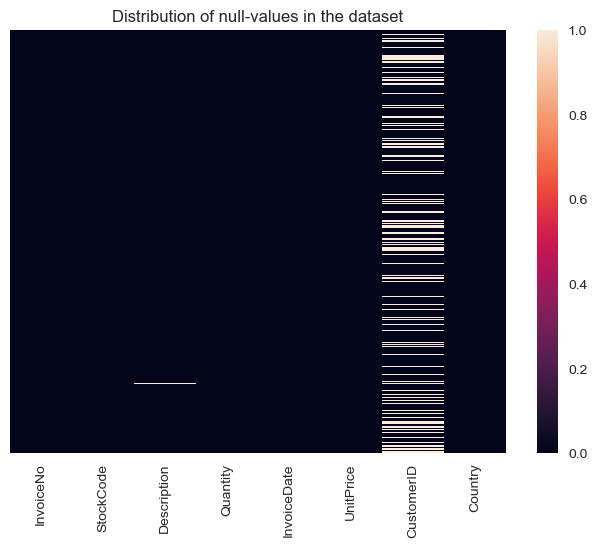

In [11]:
# Visualize the presence of null-values
sns.heatmap(df.isnull(), yticklabels=False)
plt.title('Distribution of null-values in the dataset');

There is a very minute percentage of null values associated with the "Description" feature. It is safe to drop these observations.

In [12]:
#Drop null-values in the Description column
df.dropna(subset=['Description'],inplace=True)

In [13]:
df_info()

,data_type,null_count,null_percentage %,unique_count
InvoiceNo,object,0,0.000000,24446
StockCode,object,0,0.000000,3958
Description,object,0,0.000000,4223
Quantity,int64,0,0.000000,671
InvoiceDate,datetime64[ns],0,0.000000,22309
UnitPrice,float64,0,0.000000,1630
CustomerID,float64,133626,24.724723,4372
Country,object,0,0.000000,38


In [14]:
#Check for duplicated rows(observations)
print('There are {} duplicate rows (customer purchases).'.format(df.duplicated().sum()))

There are 5268 duplicate rows (customer purchases).


In [15]:
df[df.duplicated()== True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [16]:
# Drop duplicated rows
df=df[~df.duplicated()]

##### We will clean the data by carefully checking each feature in the dataset.

### InvoiceNo

In [17]:
# Check for columns containing negative values
df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


We can infer that negative quatity-values indicates that these orders were returned or cancelled.  

In [18]:
#Confirm if all InvoiceNo starting with 'C' corresponds to returned or cancelled orders
len(df[(df['InvoiceNo'].str.startswith('C')==True)])

9251

In [19]:
len(df[df['Quantity']<0])

9725

Since the lengths are not equal this means that we have some returned orders whose InvoiceNo does not start with 'C'. Lets drop the identified InvoiceNo


In [20]:
df=(df[(df['InvoiceNo'].str.startswith('C')!=True)])
print('There are still about {} negative quantity-values.'.format(len(df[df['Quantity']<0])))

There are still about 474 negative quantity-values.


### StockCode

In [21]:
# Check for number of unique stockcode count
df['StockCode'].nunique()

3943

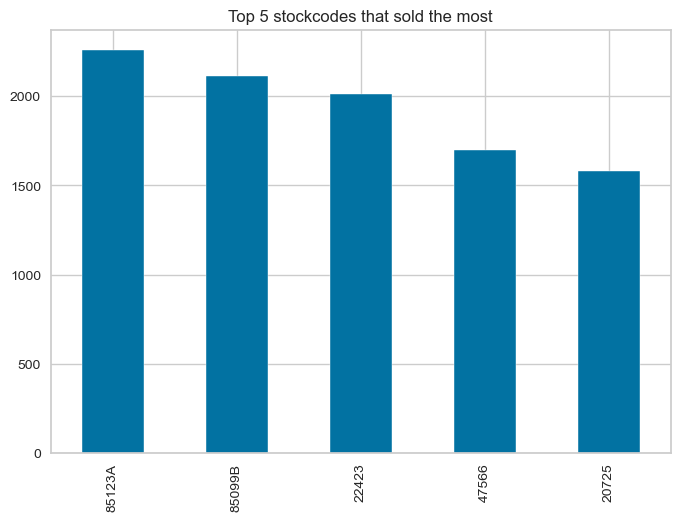

In [22]:
# Top 5 stockcodes that sold the most
df['StockCode'].value_counts().head().plot(
    kind='bar',title='Top 5 stockcodes that sold the most'
);

### Quantity

In [23]:
# Statistical Analysis of the feature
df['Quantity'].describe()

count    525936.000000
mean         10.365655
std         160.075723
min       -9600.000000
25%           1.000000
50%           3.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

The minimum value is negative and judging by the 25th percentile, we can infer that there are still negative-Quantity values.

In [24]:
# Check for columns containing negative values
df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom
13264,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom
21338,538072,22423,faulty,-13,2010-12-09 14:10:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


In [25]:
# Let's remove these negative-quantity values
df=df[df['Quantity']>0]

In [26]:
df['Quantity'].describe()

count    525462.000000
mean         10.681024
std         157.399272
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

### InvoiceDate

In [27]:
print('Minimum date of purchase:',df['InvoiceDate'].min())
print('Maximum date of purchase:',df['InvoiceDate'].max())

Minimum date of purchase: 2010-12-01 08:26:00
Maximum date of purchase: 2011-12-09 12:50:00


### UnitPrice

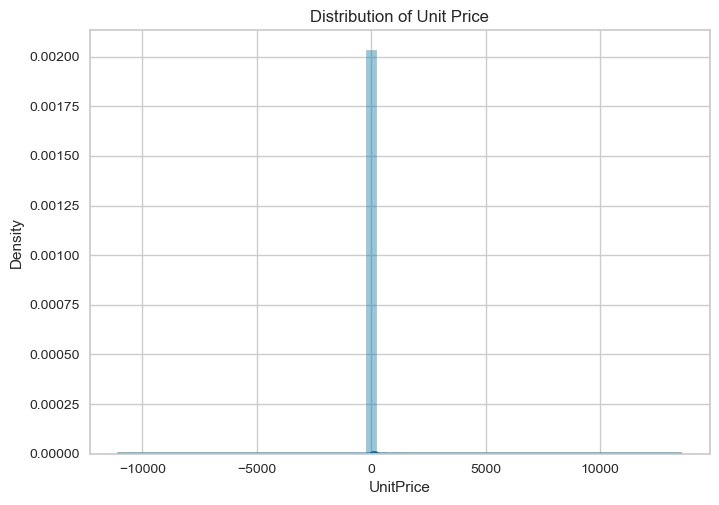

In [28]:
#Visualize the distribution of price
sns.distplot(df['UnitPrice'])
sns.set_style('darkgrid')
plt.title('Distribution of Unit Price');

We can infer that there are negative and 0 values indicating cancelled or returned orders.We will drop these values during the data cleaning process.

In [29]:
# Drop Unit Price values less than 0
df=df[df['UnitPrice']>0]

In [30]:
# Statistical analysis of the UnitPrice feature
df['UnitPrice'].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [31]:
print("About {:.2f}% of the purchases made have unit prices less than 10".format(len(df[df['UnitPrice']<10]['UnitPrice'])/len(df)*100))

About 95.45% of the purchases made have unit prices less than 10


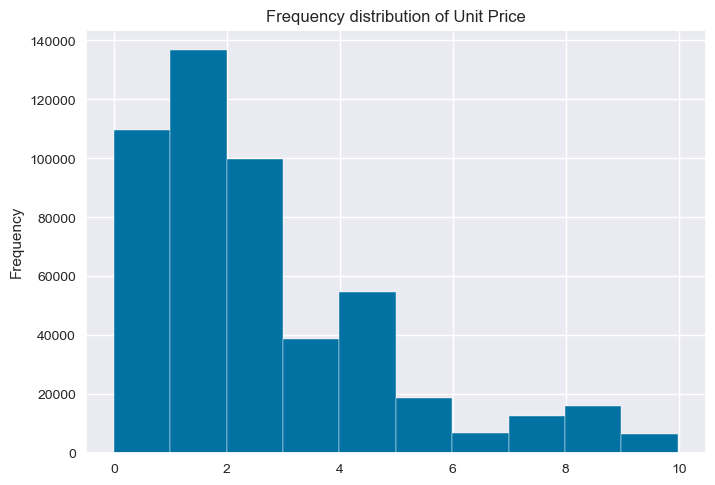

In [32]:
df[df['UnitPrice']<10]['UnitPrice'].plot(kind='hist',title='Frequency distribution of Unit Price');

Majority of purchase orders have unit price values between 0.2 and 3.

### CustomerID

In [33]:
# Check for null-values
df_info()

,data_type,null_count,null_percentage %,unique_count
InvoiceNo,object,0,0.000000,19960
StockCode,object,0,0.000000,3922
Description,object,0,0.000000,4026
Quantity,int64,0,0.000000,375
InvoiceDate,datetime64[ns],0,0.000000,18499
UnitPrice,float64,0,0.000000,1291
CustomerID,float64,132186,25.184138,4338
Country,object,0,0.000000,38


About 25% of the data lacks CustomerID values. We can fairly drop the null-values during the data cleaning process.

In [34]:
df.dropna(subset=['CustomerID'], inplace=True)

In [35]:
df_info()

,data_type,null_count,null_percentage %,unique_count
InvoiceNo,object,0,0.0,18532
StockCode,object,0,0.0,3665
Description,object,0,0.0,3877
Quantity,int64,0,0.0,301
InvoiceDate,datetime64[ns],0,0.0,17282
UnitPrice,float64,0,0.0,440
CustomerID,float64,0,0.0,4338
Country,object,0,0.0,37


### Country

In [36]:
#Check for the frequency count of the countries in the data
df['Country'].value_counts()

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [37]:
df['Country'].value_counts(normalize=True)*100

United Kingdom          88.925417
Germany                  2.298239
France                   2.120237
EIRE                     1.840119
Spain                    0.631284
Netherlands              0.600725
Belgium                  0.517199
Switzerland              0.468815
Portugal                 0.370010
Australia                0.300745
Norway                   0.272733
Italy                    0.193027
Channel Islands          0.190225
Finland                  0.174437
Cyprus                   0.153555
Sweden                   0.114594
Austria                  0.101352
Denmark                  0.096768
Poland                   0.084035
Japan                    0.081743
Israel                   0.062390
Unspecified              0.061371
Singapore                0.056533
Iceland                  0.046347
USA                      0.045583
Canada                   0.038453
Greece                   0.036925
Malta                    0.028521
United Arab Emirates     0.017316
European Commu

Since about 89% of the purchases were made in the UK then it is safe to categorize the remaining countries into a single group.

In [38]:
df['Country']=df['Country'].apply(lambda x:'Others' if x != 'United Kingdom' else 'United Kingdom')
df['Country'].value_counts(normalize=True)*100

United Kingdom    88.925417
Others            11.074583
Name: Country, dtype: float64

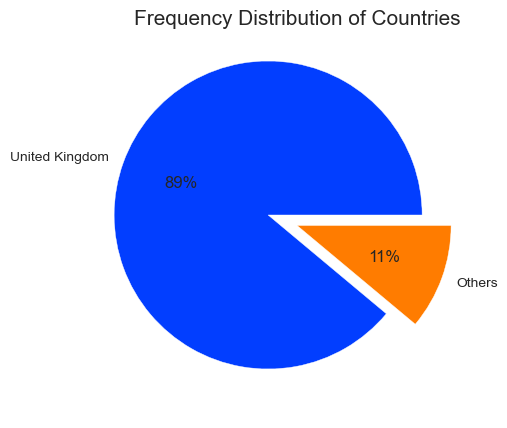

In [39]:
#Frequency distribution of countries using a pie chart
plt.figure(figsize=(8,5))
data = list(list((df['Country'].value_counts(normalize=True)*100)))
labels = list((df['Country'].value_counts(normalize=True)*100).index)
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
explode = (0.2,0)
#create pie chart
plt.pie(data, labels = labels,explode=explode, colors = colors, autopct='%.0f%%')
plt.title('Frequency Distribution of Countries',size = 15)
plt.show()

### Description

In [40]:
# Unique items in the 
df['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [41]:
print('There are {} unique items that were ordered.'.format(df['Description'].nunique()))

There are 3877 unique items that were ordered.


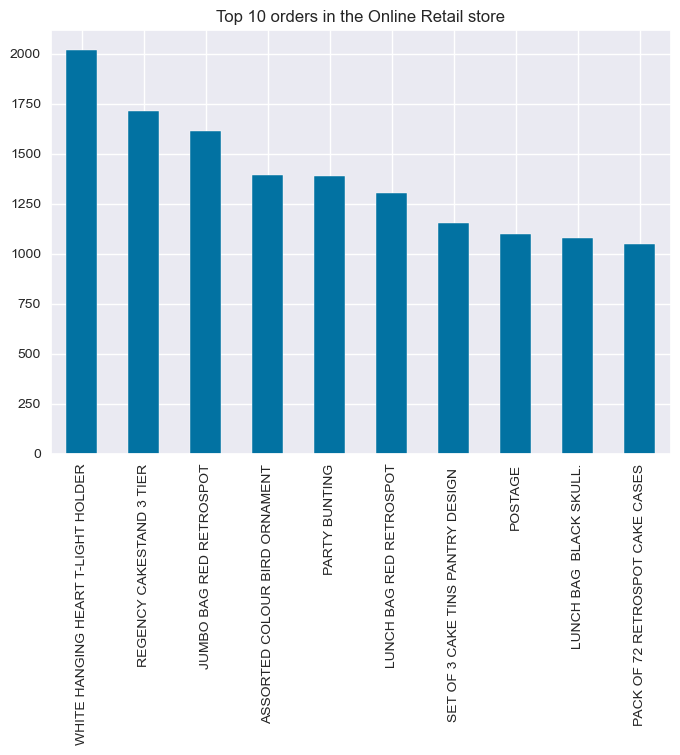

In [42]:
#Check for the top 10 orders
df['Description'].value_counts().head(10).plot(
    kind='bar',
    title='Top 10 orders in the Online Retail store'
);

In [43]:
#Check for error-orders that do not start with letters
df[df['Description'].str.startswith('*')==True].shape

(0, 8)

In [44]:
# Most descriptions were written completely in upper-case.Lets check for the other descriptions written in other forms.
df[df['Description'].str.isupper()!=True]['Description'].value_counts()

Manual                                 279
BAG 125g SWIRLY MARBLES                247
3 TRADITIONAl BISCUIT CUTTERS  SET     203
BAG 250g SWIRLY MARBLES                198
POLYESTER FILLER PAD 40x40cm           182
POLYESTER FILLER PAD 45x45cm           134
BAG 500g SWIRLY MARBLES                112
Next Day Carriage                       79
FRENCH BLUE METAL DOOR SIGN No          73
POLYESTER FILLER PAD 45x30cm            37
POLYESTER FILLER PAD 30CMx30CM          26
ESSENTIAL BALM 3.5g TIN IN ENVELOPE     18
Bank Charges                            12
NUMBER TILE COTTAGE GARDEN No           11
FOLK ART GREETING CARD,pack/12           9
NUMBER TILE VINTAGE FONT No              7
THE KING GIFT BAG 25x24x12cm             7
POLYESTER FILLER PAD 65CMx65CM           5
FLOWERS HANDBAG blue and orange          3
High Resolution Image                    3
POLYESTER FILLER PAD 60x40cm             1
Name: Description, dtype: int64

In [45]:
df[df['Description'].str.istitle()==True]['Description'].value_counts()

Manual                   279
Next Day Carriage         79
Bank Charges              12
High Resolution Image      3
Name: Description, dtype: int64

We can infer that the above descriptions are mistake-orders or rather do not give useful information for analysis.

In [46]:
# Drop these orders to reduce noise in the data
df=df[df['Description'].str.istitle()!=True]

In [47]:
# Remove any trailing characters
df['Description'].str.strip()

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905            CHILDREN'S APRON DOLLY GIRL
541906           CHILDRENS CUTLERY DOLLY GIRL
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908           BAKING SET 9 PIECE RETROSPOT
Name: Description, Length: 392319, dtype: object

In [48]:
# Final check on the data after cleaning
df_info()

,data_type,null_count,null_percentage %,unique_count
InvoiceNo,object,0,0.0,18454
StockCode,object,0,0.0,3661
Description,object,0,0.0,3873
Quantity,int64,0,0.0,299
InvoiceDate,datetime64[ns],0,0.0,17215
UnitPrice,float64,0,0.0,390
CustomerID,float64,0,0.0,4334
Country,object,0,0.0,2


# EDA (Exploratory Data Analysis)

In [49]:
#Preview of the cleaned data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392319 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392319 non-null  object        
 1   StockCode    392319 non-null  object        
 2   Description  392319 non-null  object        
 3   Quantity     392319 non-null  int64         
 4   InvoiceDate  392319 non-null  datetime64[ns]
 5   UnitPrice    392319 non-null  float64       
 6   CustomerID   392319 non-null  float64       
 7   Country      392319 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 26.9+ MB


In [51]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,392319.000000,392319.000000,392319.000000
mean,13.114262,2.998467,15287.721245
std,180.539181,15.046447,1713.437809
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [52]:
# Create useful columns that will be used for analysis
df['Amount']= df['Quantity'] * df['UnitPrice']
df['Year']= df['InvoiceDate'].dt.year
df['Month']= df['InvoiceDate'].dt.month
df['Day']= df['InvoiceDate'].dt.day
df['Hour']= df['InvoiceDate'].dt.hour
df['Day_of_week']=df['InvoiceDate'].dt.dayofweek

In [53]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Year,Month,Day,Hour,Day_of_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2


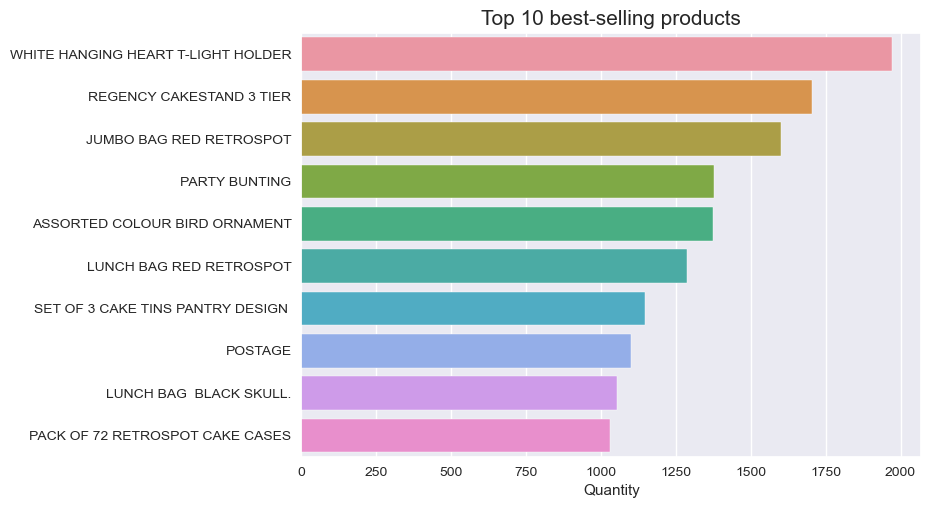

In [54]:
# Top 10 products purchased by customers
y=df.groupby('Description')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).index
x=df.groupby('Description')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).values
sns.barplot(x=x, y=y)
plt.xlabel('Quantity')
plt.ylabel('')
plt.title('Top 10 best-selling products',size=15);

#### Is there a relationship between Quantity of goods purchased and the Unit Price?

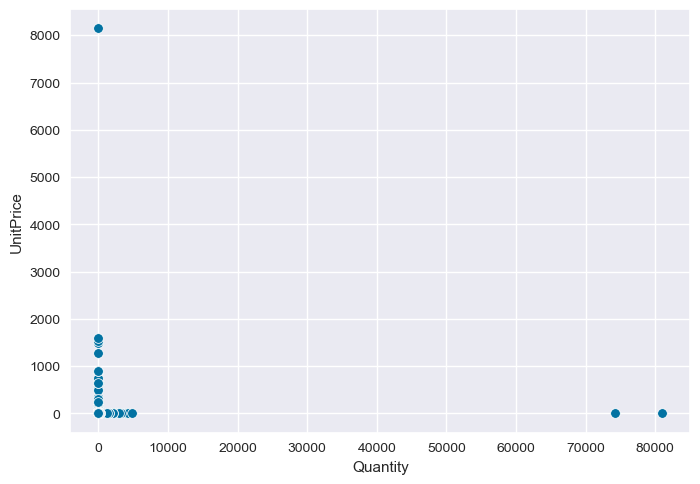

In [55]:
sns.scatterplot(x=df['Quantity'], y=df['UnitPrice']);

We can infer from the plot that the quantity of goods purchased by customers is independent of the unit price of goods.

In [56]:
#Check for correlated features
df.corr()

,Quantity,UnitPrice,CustomerID,Amount,Year,Month,Day,Hour,Day_of_week
Quantity,1.000000,-0.006188,-0.006121,0.915865,0.001452,-0.004115,-0.001159,-0.014689,-0.007709
UnitPrice,-0.006188,1.000000,-0.009520,0.063897,-0.002508,-0.006984,-0.001311,-0.000713,-0.006269
CustomerID,-0.006121,-0.009520,1.000000,-0.003599,-0.035650,0.029653,-0.002651,0.065804,0.019856
Amount,0.915865,0.063897,-0.003599,1.000000,0.000236,-0.002552,-0.001966,-0.013122,-0.007238
Year,0.001452,-0.002508,-0.035650,0.000236,1.000000,-0.340594,0.168130,-0.019713,-0.017067
Month,-0.004115,-0.006984,0.029653,-0.002552,-0.340594,1.000000,-0.117305,0.058547,0.025790
Day,-0.001159,-0.001311,-0.002651,-0.001966,0.168130,-0.117305,1.000000,0.008962,-0.005167
Hour,-0.014689,-0.000713,0.065804,-0.013122,-0.019713,0.058547,0.008962,1.000000,0.036717
Day_of_week,-0.007709,-0.006269,0.019856,-0.007238,-0.017067,0.025790,-0.005167,0.036717,1.000000


In [57]:
#check for highly correlated features in the data
df.corr()[(df.corr()>0.5)|(df.corr()<-0.5)] 

,Quantity,UnitPrice,CustomerID,Amount,Year,Month,Day,Hour,Day_of_week
Quantity,1.000000,NaN,NaN,0.915865,NaN,NaN,NaN,NaN,NaN
UnitPrice,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerID,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Amount,0.915865,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Year,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Month,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Day,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Day_of_week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


High correlations exist between the 'Amount' and the 'Quantity' features. This is inferrable because the 'Amount' was derived using the 'Quantity' feature. Therefore, not much info is provided by this correlation.

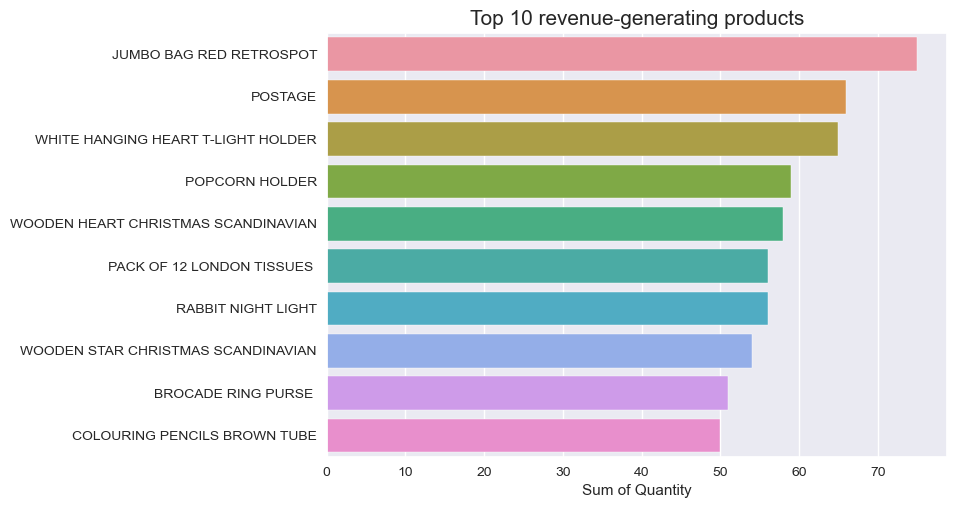

In [58]:
# Top 10 products with most sales
y=df.groupby('Description')['Amount'].nunique().sort_values(ascending=False).head(10).index
x=df.groupby('Description')['Amount'].nunique().sort_values(ascending=False).head(10).values
sns.barplot(x=x, y=y)
plt.xlabel('Sum of Quantity')
plt.ylabel('')
plt.title('Top 10 revenue-generating products',size=15);

Even though most people buy the "Whit Hanging Heart T-Light Holder" from the online store, the store generates most of its revenue from the 'Jumbo Bag Red Retrospot' purchase

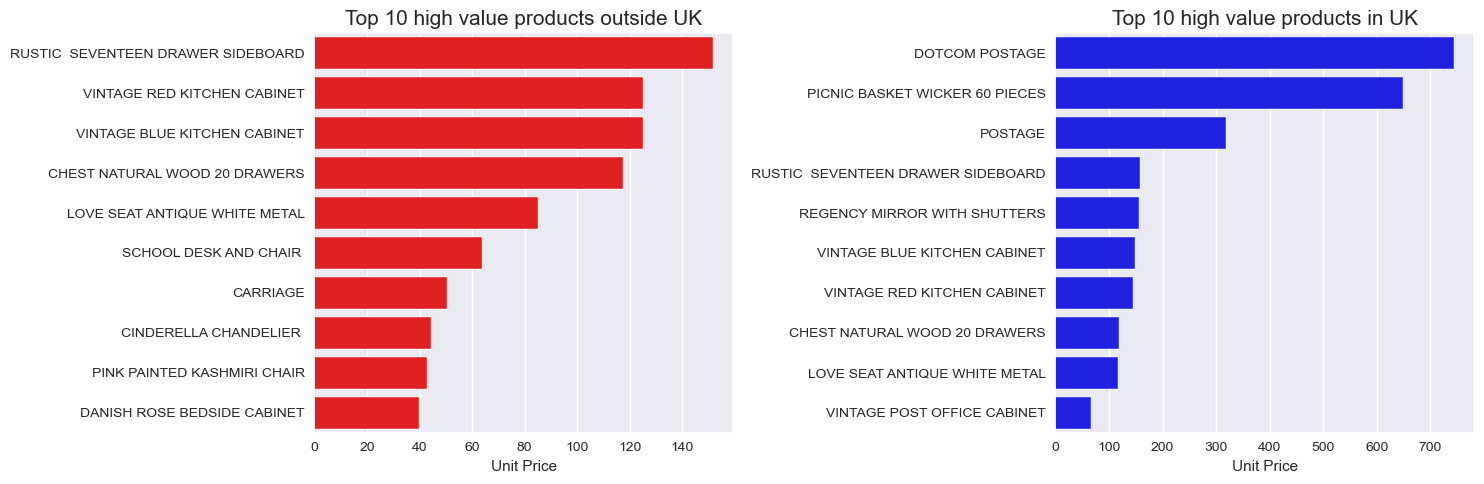

In [59]:
# Visualization of high-value products
column = ['Others','United Kingdom']
color=['red','blue']
plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(1,2,i+1)
    sns.barplot(x = df[df['Country']==j].groupby('Description')['UnitPrice'].mean().sort_values(ascending=False).head(10).values,
                y = df[df['Country']==j].groupby('Description')['UnitPrice'].mean().sort_values(ascending=False).head(10).index,
                color=color[i])
    plt.ylabel('')
    if i==0:
        plt.xlabel('Unit Price')
        plt.title('Top 10 high value products outside UK',size=15)
    else:
        plt.xlabel('Unit Price')
        plt.title('Top 10 high value products in UK',size=15)
        
plt.tight_layout()
plt.show()

In [60]:
# Are there products in UK which are also purchased outside UK at different prices?
df['UnitPrice'].nunique() == df['Description'].nunique()

False

In [61]:
# Mask out products that are sold both in the UK and outside the UK
s1 = df[df['Country']=='United Kingdom']['Description']
s2 = df[df['Country']=='Others']['Description']
pd.Series(list(set(s1) & set(s2))).head()[0]

'SILVER CHRISTMAS TREE BAUBLE STAND '

In [62]:
df[df['Description']=='SKULLS WRITING SET '][df['Country']=='Others']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Year,Month,Day,Hour,Day_of_week
306926,563854,21327,SKULLS WRITING SET,12,2011-08-19 15:24:00,1.65,12364.0,Others,19.8,2011,8,19,15,4


In [63]:
df[df['Country']=='United Kingdom'].groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(10)

CustomerID
18102.0    259657.30
17450.0    194390.79
16446.0    168472.50
17511.0     91062.38
16029.0     80850.84
12346.0     77183.60
16684.0     66653.56
14096.0     65164.79
13694.0     65039.62
15311.0     60632.75
Name: Amount, dtype: float64

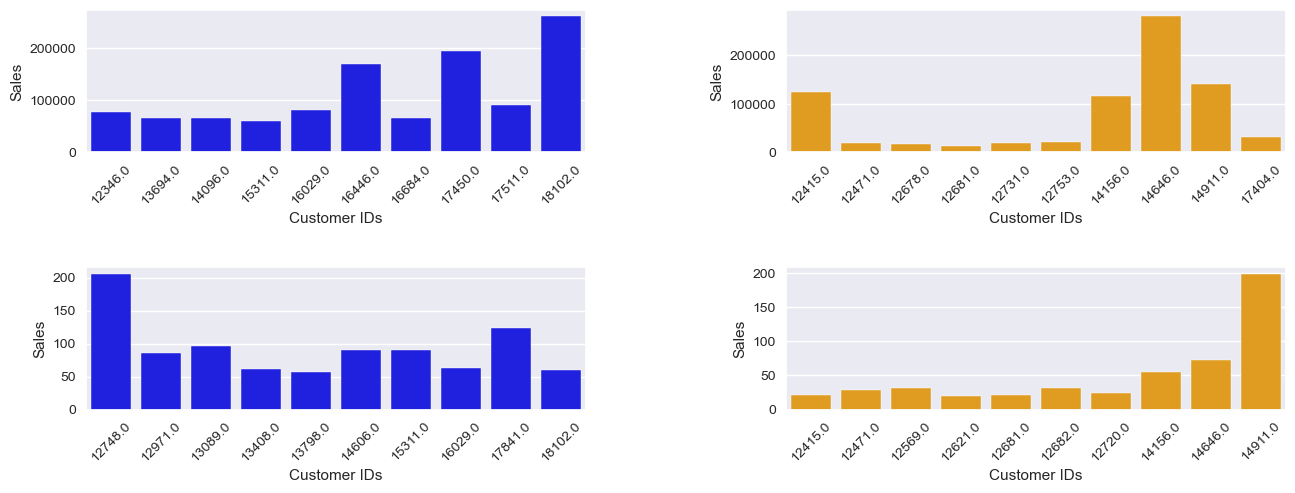

In [64]:
# Top customers in terms of sales and in terms of frequency of purchase
plt.figure(figsize=(15,5))

# Top 10 customers in terms of sales in Uk
plt.subplot(2,2,1)
# set the spacing between subplots
x_1=df[df['Country']=='United Kingdom'].groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(10).index
y_1=df[df['Country']=='United Kingdom'].groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(10).values
sns.barplot(x=x_1, y=y_1 ,color='blue')
plt.ylabel('Sales')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)
# Top 10 customers in terms of frequency of purchase in UK
plt.subplot(2,2,3)
x_1=df[df['Country']=='United Kingdom'].groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).index
y_1=df[df['Country']=='United Kingdom'].groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).values
sns.barplot(x=x_1, y=y_1 ,color='blue')
plt.ylabel('Sales')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)

# Top 10 customers in terms of sales in other countries
plt.subplot(2,2,2)
x_1=df[df['Country']!='United Kingdom'].groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(10).index
y_1=df[df['Country']!='United Kingdom'].groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(10).values
sns.barplot(x=x_1, y=y_1 ,color='orange')
plt.ylabel('Sales')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)

# Top 10 customers in terms of frequency of purchase in other countries
plt.subplot(2,2,4)
x_1=df[df['Country']!='United Kingdom'].groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).index
y_1=df[df['Country']!='United Kingdom'].groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).values
sns.barplot(x=x_1, y=y_1 ,color='orange')
plt.ylabel('Sales')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.8);

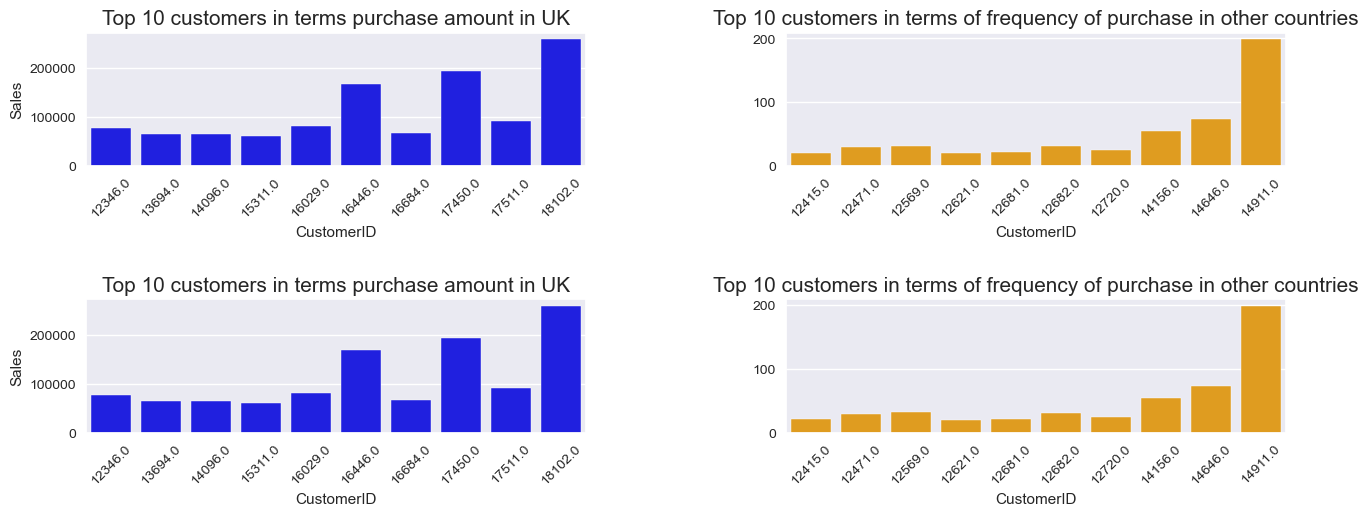

In [65]:
# Visualization of high-value products
column = ['United Kingdom','Others','United Kingdom','Others']
color=['blue','orange','blue','orange']
sub=['Amount','InvoiceNo','Amount','InvoiceNo']
count=[1,2,3,4]
plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(2,2,i+1)
    if column[i]=='United Kingdom':
        plt.xlabel('Customer IDs')
        plt.ylabel('Sales')
        plt.xticks(rotation=45)
        if sub[i]=='Amount':
            sns.barplot(x = df[df['Country']==j].groupby('CustomerID')[sub[i]].sum().sort_values(ascending=False).head(10).index,
                        y = df[df['Country']==j].groupby('CustomerID')[sub[i]].sum().sort_values(ascending=False).head(10).values,
                        color=color[i])
            plt.title('Top 10 customers in terms purchase amount in UK',size=15)
        if sub[i]=='InvoiceNo':
            sns.barplot(x = df[df['Country']==j].groupby('CustomerID')[sub[i]].nunique().sort_values(ascending=False).head(10).index,
                        y = df[df['Country']==j].groupby('CustomerID')[sub[i]].nunique().sort_values(ascending=False).head(10).values,
                        color=color[i])
            plt.title('Top 10 customers in terms of frequency of purchase in UK',size=15)
    else:
        plt.xlabel('Customer IDs')
        plt.xticks(rotation=45)
        if sub[i]=='Amount':
            sns.barplot(x = df[df['Country']==j].groupby('CustomerID')[sub[i]].sum().sort_values(ascending=False).head(10).index,
                        y = df[df['Country']==j].groupby('CustomerID')[sub[i]].sum().sort_values(ascending=False).head(10).values,
                        color=color[i])
            plt.title('Top 10 customers in terms purchase amount in other countries',size=15)
        if sub[i]=='InvoiceNo':
            sns.barplot(x = df[df['Country']==j].groupby('CustomerID')[sub[i]].nunique().sort_values(ascending=False).head(10).index,
                        y = df[df['Country']==j].groupby('CustomerID')[sub[i]].nunique().sort_values(ascending=False).head(10).values,
                        color=color[i])
            plt.title('Top 10 customers in terms of frequency of purchase in other countries',size=15)
        

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=1.0);
plt.show()

In [66]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Year,Month,Day,Hour,Day_of_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2


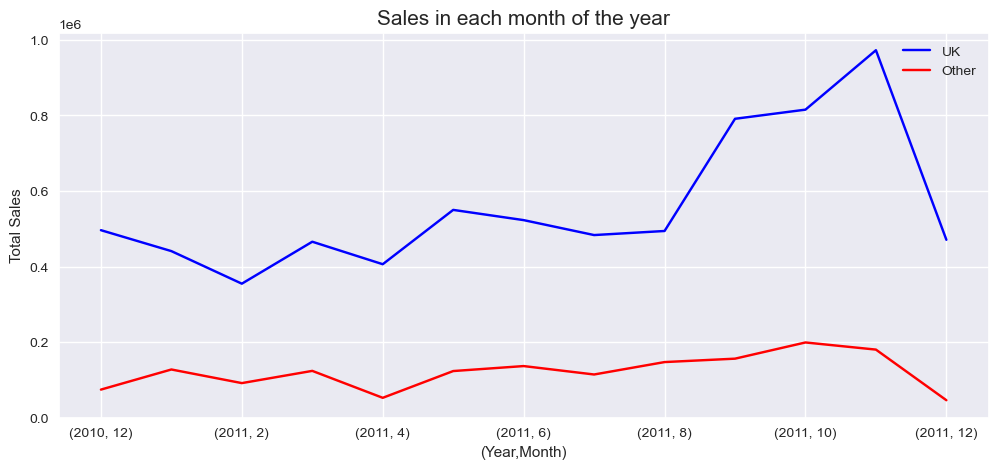

In [67]:
# Analysis of monthly sales' cycle
plt.figure(figsize=(12,5))
# For the UK 
df[df['Country']=='United Kingdom'].groupby(['Year','Month'])['Amount'].sum().plot(
    kind='line',
    label='UK',
    color='blue'
)
# For outside the UK
df[df['Country']!='United Kingdom'].groupby(['Year','Month'])['Amount'].sum().plot(
    kind='line',
    label='Other',
    color='red'
)
plt.xlabel('(Year,Month)')
plt.ylabel('Total Sales')
plt.title('Sales in each month of the year',size=15)
plt.legend(fontsize=10)
plt.show();

Generally, January, February, and March are considered the toughest months in eCommerce. They fall right after the months-long Holiday season and right before the Easter Holidays.Every year, Shoppers engage in massive shopping sprees during the last three months of the year, and shopping is the last thing on their minds as the new year starts.Hence, the rapid decline in sales from January.

As a matter of fact, the sales dip as low as 30% during the Summer months since pockets are recovering from the holiday season.

Also, after the month-long break, people get back to work or college and they no longer spend much time browsing through online stores.Apart from that, essentials aside, there is not much cause for shopping during these months.

Then the cycle continues again marked by a rapid increase in sales towards the "ember" months.


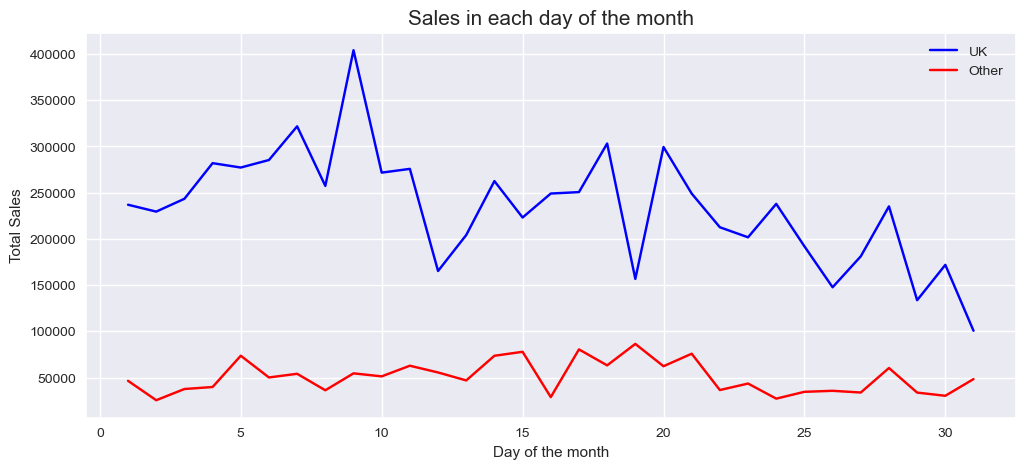

In [68]:
# Analysis of daily sales' cycle in a month
plt.figure(figsize=(12,5))
# For the UK 
df[df['Country']=='United Kingdom'].groupby(['Day'])['Amount'].sum().plot(
    kind='line',
    label='UK',
    color='blue'
)
# For outside the UK
df[df['Country']!='United Kingdom'].groupby(['Day'])['Amount'].sum().plot(
    kind='line',
    label='Other',
    color='red'
)
plt.xlabel('Day of the month')
plt.ylabel('Total Sales')
plt.title('Sales in each day of the month', size=15)
plt.legend(fontsize=10)
plt.show();

Monthly sales patterns are heavily influenced by pay dates, with the peak days for sales coming at the beginning and end of each month, when people are more likely to have money to spend.
We can infer a major deep in sales at mid month periods both in the UK and outside the UK. These are periods when most people have exhausted their salaries due to reckless spending while others are on a strict budget.
Hence, influencing the trend in sales and purchase.

In [69]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Year,Month,Day,Hour,Day_of_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2


In [70]:
#Convert numerical tags to days of the week
df['Day_name']=df['Day_of_week'].replace([0,1,2,3,4,5,6],['Sun','Mon','Tue','Wed','Thur','Fri','Sat'])

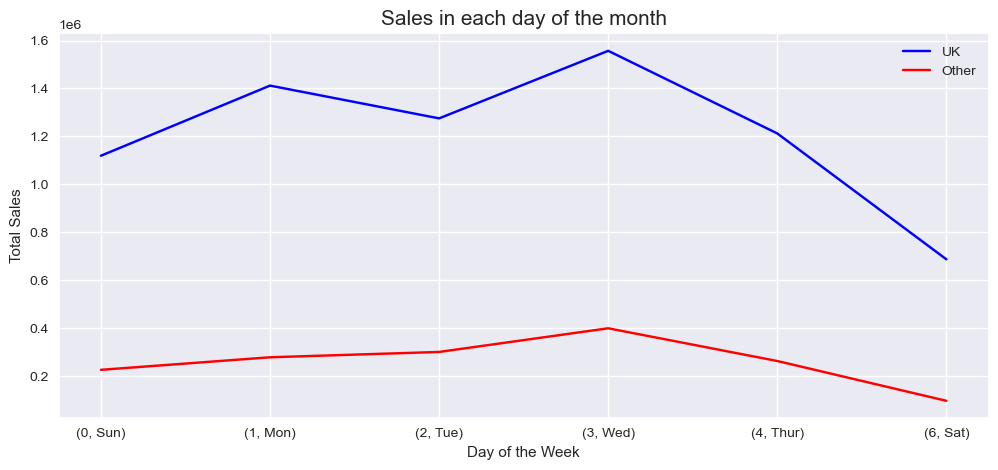

In [71]:
# Analysis of daily sales' cycle in a week
plt.figure(figsize=(12,5))
# For the UK 
df[df['Country']=='United Kingdom'].groupby(['Day_of_week','Day_name'])['Amount'].sum().sort_index().plot(
    kind='line',
    label='UK',
    color='blue'
)
# For outside the UK
df[df['Country']!='United Kingdom'].groupby(['Day_of_week','Day_name'])['Amount'].sum().sort_index().plot(
    kind='line',
    label='Other',
    color='red'
)
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.title('Sales in each day of the month', size=15)
plt.legend(fontsize=10)
plt.show();

Salespeople close the highest number of deals and complete the highest number of sales activities on Wednesdays, according to global sales data from sales management company Pipedrive. We observe the same trend in this data with most deals being closed on wednesdays.It should be noted that the dataset doesn't contain purchases made on Fridays.

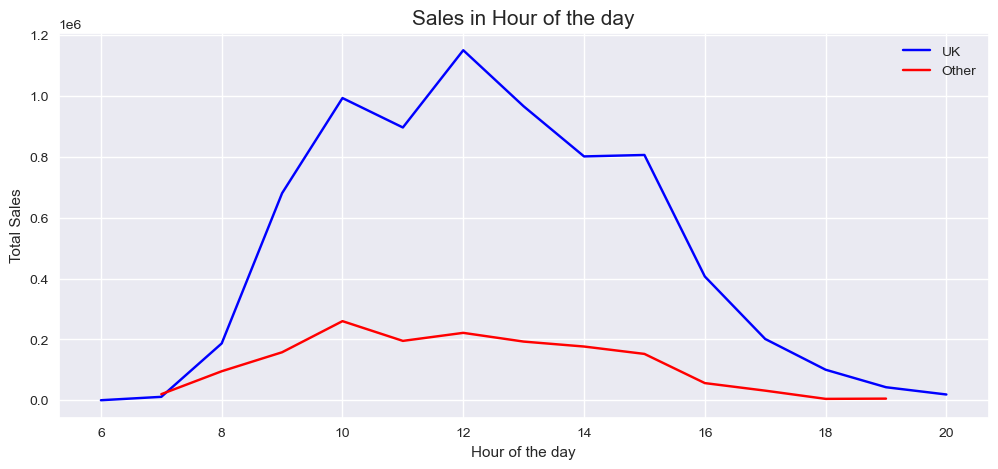

In [72]:
# Analysis of hourly sales' cycle in a day
plt.figure(figsize=(12,5))
# For the UK 
df[df['Country']=='United Kingdom'].groupby(['Hour'])['Amount'].sum().plot(
    kind='line',
    label='UK',
    color='blue'
)
# For outside the UK
df[df['Country']!='United Kingdom'].groupby(['Hour'])['Amount'].sum().plot(
    kind='line',
    label='Other',
    color='red'
)
plt.xlabel('Hour of the day')
plt.ylabel('Total Sales')
plt.title('Sales in Hour of the day', size=15)
plt.legend(fontsize=10)
plt.show();

Online sales broadly follow people’s daily patterns, with sales dipping overnight before beginning to build up from around 6am, and growing throughout the rest of the day – so this general trend rings true in most recent findings.
Sales hit its peak between the 10-14 hours both in the Uk and outside as this corresponds to break/lunch times generally in organizations, schools and other workplaces.

In [73]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Year,Month,Day,Hour,Day_of_week,Day_name
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,2,Tue
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,Tue
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,2,Tue
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,Tue
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,Tue


In [74]:
# How many orders where placed by each customer
n_orders=df.groupby(['CustomerID'])['InvoiceNo'].nunique()
multi_orders_per_customer=np.sum(n_orders>1)/df['CustomerID'].nunique()
print('On the average about {:.2f}% of customers ordered more than once.'.format(multi_orders_per_customer*100))

On the average about 65.48% of customers ordered more than once.


This information is very useful for our subsequent analysis. Since the customers make multiple orders, this implies that there should be some level of retention.

In [75]:
n_orders

CustomerID
12346.0     1
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4334, dtype: int64

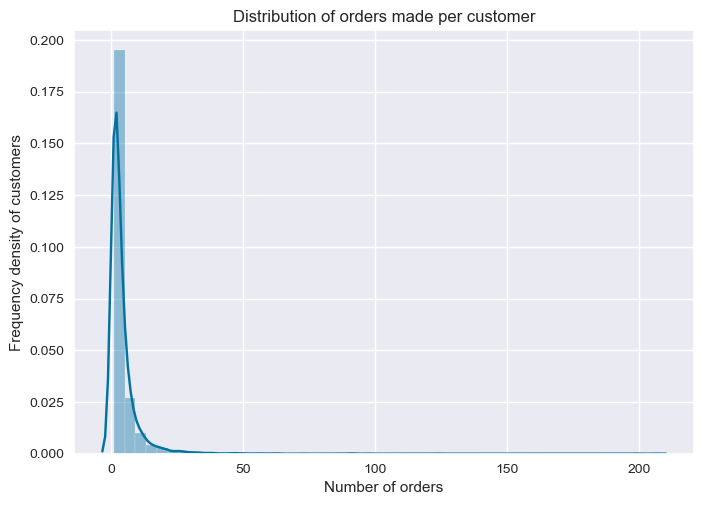

In [76]:
#Visualize the distribution of orders
sns.distplot(n_orders, kde=True)
plt.xlabel('Number of orders')
plt.ylabel('Frequency density of customers')
plt.title('Distribution of orders made per customer');

From the KDE distplot we observe that a minute fraction of customers ordered more than 50 times.This ofcourse is unusual but it can be likened to be associated with wholesalers, retailers, small businesses that buy commodities frequently for resale.Lets get a closer look on the distribution for customers that ordered more than 50 times.

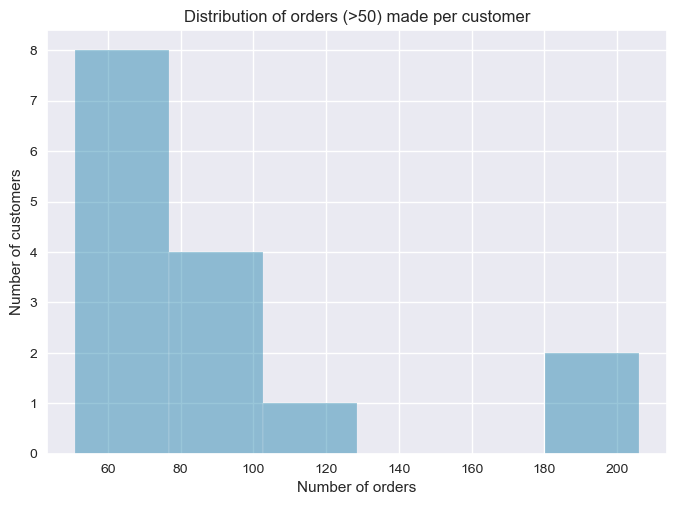

In [77]:
#Visualize the distribution of orders
sns.distplot(n_orders[n_orders>50], kde=False)
plt.xlabel('Number of orders')
plt.ylabel('Number of customers')
plt.title('Distribution of orders (>50) made per customer');

In [78]:
# Merge 2 kdes for best selling products and revenue-generating products 

# Cohort Analysis

Cohort Analysis is a very useful and relatively simple technique that helps in getting valuable insights about the behavior of any business’ customers/users. For the analysis, we can focus on different metrics (dependent on the business model) — conversion, retention, generated revenue, etc. but we will be streamlining our focus to customer retention.

By understanding user retention, we can infer the loyalty of the customers and evaluate the health of the business. It is important to remember that the expected retention values vary greatly between businesses, 3 purchases a year for one retailer might be a lot, while for another might be far too little.Retaining customers is critical for any business, as it is far cheaper to keep the current customers (by using CRM tools, member discounts, etc.) than to acquire new ones.

In [79]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Year,Month,Day,Hour,Day_of_week,Day_name
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,2,Tue
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,Tue
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,2,Tue
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,Tue
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,Tue


In [80]:
# Keep relevant columns and drop duplicates
df_ = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

For cohort analysis, there are a few labels that we have to create:
- Invoice Month: A string representation of the year and month of a single transaction/invoice.
- Cohort Month: A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
- Cohort period: A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [81]:
df_['order_month'] = df_['InvoiceDate'].dt.to_period('M')
df_['cohort'] = df_.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M') 

In [82]:
df_

,CustomerID,InvoiceNo,InvoiceDate,order_month,cohort
0,17850.0,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12,2010-12
...,...,...,...,...,...
541865,13777.0,581583,2011-12-09 12:23:00,2011-12,2010-12
541867,13777.0,581584,2011-12-09 12:25:00,2011-12,2010-12
541869,15804.0,581585,2011-12-09 12:31:00,2011-12,2011-05
541890,13113.0,581586,2011-12-09 12:49:00,2011-12,2010-12


In [83]:
df_cohort = df_.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [84]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [85]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

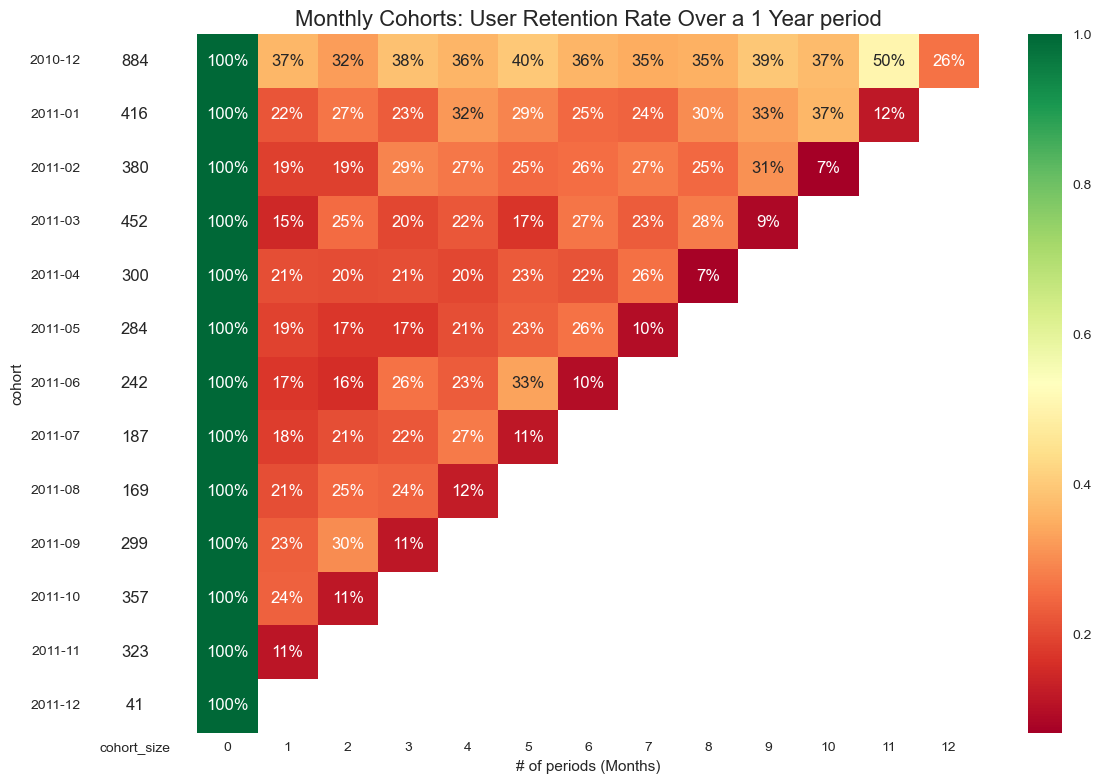

In [86]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention Rate Over a 1 Year period', fontsize=16)
    ax[1].set(xlabel='# of periods (Months)',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()


# Useful insights from the Cohort Analysis

- For all cohorts with the first cohort as an exception,only an average of 20% of customers were retained.
- There is a 50% retention of customers for the first cohort.
- All through 2011, theres an average of 90% loss of customers for all cohorts.
- There is a relatively fair retention rate in November as customers a placing orders in preparation for the festive period.

# RFM Analysis

In ecommerce, RFM can tell you a huge amount and is central to nearly every type of model used.Customers who are more recent, more frequent, and have spent more are more likely to purchase again, so the RFM model data can tell us which customers are most active, which are most valuable, and which are most likely to be lapsed, or are about to lapse.

“RFM is a method used for analyzing customer value”.

It groups customers based on their transaction history :

- Recency — How recently did the customer purchase? when is the last time the user takes an action (e.g.place an order)?
- Frequency — How many times does the user take this action? How often do they purchase? 
- Monetary Value — How much do they spend? what is the sum of monetary value from this user throughout his/her lifetime?

In [87]:
# Initialize a copy of the dataframe
df_rfm=df.copy()
#Select only useful columns
df_rfm=df_rfm.loc[:,'InvoiceNo':'Amount']
df_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


For RFM analysis, We need a few details of each Customer:

### Recency
- Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?

In [88]:
# Extraxt recency
df_recency=pd.DataFrame(df_rfm.groupby('CustomerID')['InvoiceDate'].max().reset_index())
# Convert to datetime and extract the date only
df_recency['InvoiceDate']=pd.to_datetime(df_recency['InvoiceDate']).dt.date
df_recency['Max_InvoiceDate']=df_recency['InvoiceDate'].max()
df_recency['Recency']=(df_recency['Max_InvoiceDate'] - df_recency['InvoiceDate']).dt.days + 1
df_recency=df_recency[['CustomerID','Recency']]
df_recency.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,3
2,12348.0,76
3,12349.0,19
4,12350.0,311


### Frequency
- Frequency (F) as the total number of transactions: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.

In [89]:
# Extract frequency
df_frequency=df_rfm.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
df_frequency.columns=['fCustomerID','Frequency']
df_frequency.head()

,fCustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


### Monetary 
- Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent? Simply total up the money from all transactions to get the M value.

In [90]:
# Extract monetary value
df_monetary=df_rfm.groupby('CustomerID')['Amount'].sum().reset_index()
df_monetary.columns=['mCustomerID','Monetary']
df_monetary.head()

,mCustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [91]:
# Combine recency, frequency and monetary into a single df
RFM=pd.concat([df_recency,df_frequency,df_monetary],axis=1)
RFM.drop(columns=['fCustomerID','mCustomerID'], inplace=True)
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


In [92]:
# Preview ofextracted RFM values
RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4334 non-null   float64
 1   Recency     4334 non-null   int64  
 2   Frequency   4334 non-null   int64  
 3   Monetary    4334 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 135.6 KB


In [93]:
print('There are {} distinct customers.'.format(RFM.shape[0]))

There are 4334 distinct customers.


In [94]:
# Stastical summary of RFM values with careful study of the percentiles
RFM.describe(percentiles=[0.25,0.50,0.75,0.95])

,CustomerID,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,93.196354,4.257960,2037.931925
std,1721.994109,100.172795,7.656086,8967.191539
min,12346.000000,1.000000,1.000000,3.750000
25%,13812.250000,18.000000,1.000000,306.452500
50%,15297.500000,51.000000,2.000000,668.495000
75%,16778.750000,143.000000,5.000000,1651.892500
95%,17984.350000,312.000000,13.000000,5745.560500
max,18287.000000,374.000000,206.000000,280206.020000


# Approach for RFM analysis:

- As we got RFM for each customer, the goal now is to categorize the customers into different categories based upon their values.
- For this we will first of all categorize the R,F,M values into the labels 1-5. 1 being the low and 5 being the higest. Here we make cuts at 25%, 50%, 75% and 95%to distribute them into 5 categories.
- After that we sum these values for each row and label the column 'score' which have values range from 3-15.
- After that we make cuts on 'score' at 25%, 50%, 75% and 95%to categorize the customers into Bad, Bronze, Silver, Gold and Platinum.
- These cuts can be done in many ways like by discussion with the client, according to expert advise, business understanding or quartiles cuts(which we did in this) etc.

In [95]:
# Categorize the customers into different categories based upon their values.
RFM['Recency_score']=pd.cut(RFM['Recency'], bins=[0,28,51,143,312,374], labels=[5,4,3,2,1])
RFM['Frequency_score']=pd.cut(RFM['Frequency'], bins=[0,1,2,5,13,206], labels=[1,2,3,4,5])
RFM['Monetary_score']=pd.cut(RFM['Monetary'], bins=[-1,307,669,1652,5745,290206], labels=[1,2,3,4,5])
# Conert Dtype to integers
# Categorize the customers into different categories based upon their values.
RFM['Recency_score']=RFM['Recency_score'].astype('int32')
RFM['Frequency_score']=RFM['Frequency_score'].astype('int32')
RFM['Monetary_score']=RFM['Monetary_score'].astype('int32')
# Create a column of accumulated scores
RFM['Score']=RFM['Recency_score']+RFM['Frequency_score']+RFM['Monetary_score']
RFM.head()

,CustomerID,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,Score
0,12346.0,326,1,77183.60,1,1,5,7
1,12347.0,3,7,4310.00,5,4,4,13
2,12348.0,76,4,1797.24,3,3,4,10
3,12349.0,19,1,1757.55,5,1,4,10
4,12350.0,311,1,334.40,2,1,2,5


In [96]:
# Statistical Preview of the 'Score' column to check for the spread of score values
RFM['Score'].describe(percentiles=[0.25,0.50,0.75,0.95])

count    4334.000000
mean        8.467236
std         3.160264
min         3.000000
25%         6.000000
50%         8.000000
75%        11.000000
95%        14.000000
max        15.000000
Name: Score, dtype: float64

In [97]:
# We will assign customers into 4 categories based on the cummulative RFM scores obtained
RFM['Customer_segment']=pd.cut(RFM['Score'], bins=[0,7,10,12,14,16], labels=['Bad','Average','Good','Very good','Platinum'])
RFM['Cluster_RFM']=RFM['Customer_segment'].replace({'Bad':0,'Average':1,'Good':2,'Very good':3,'Platinum':4})
RFM.head()

,CustomerID,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,Score,Customer_segment,Cluster_RFM
0,12346.0,326,1,77183.60,1,1,5,7,Bad,0
1,12347.0,3,7,4310.00,5,4,4,13,Very good,3
2,12348.0,76,4,1797.24,3,3,4,10,Average,1
3,12349.0,19,1,1757.55,5,1,4,10,Average,1
4,12350.0,311,1,334.40,2,1,2,5,Bad,0


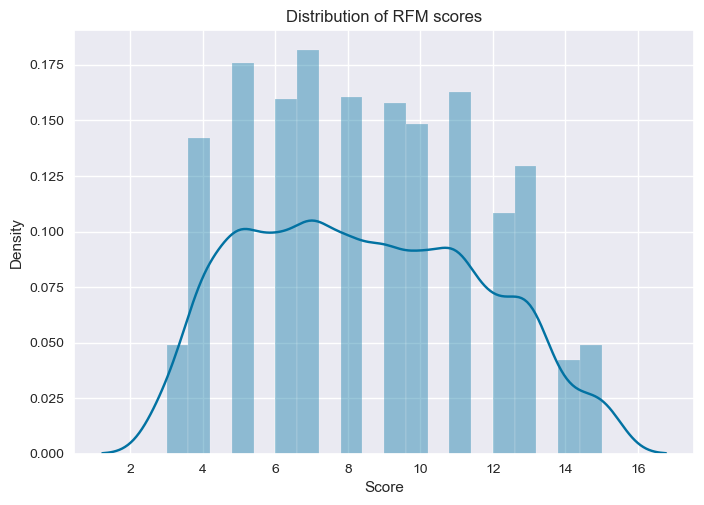

In [98]:
# Check for distribution of customer types
sns.distplot(RFM['Score'])
plt.title('Distribution of RFM scores');

There is relatively a normal distribution of customers across all 5 sub-groups but a very minute fraction of customers fall under the Platinum group while a large fraction of the customers is contained in the least performing group. We will visualize the percentage composition of each segment next.

In [99]:
(RFM['Customer_segment'].value_counts(normalize=True)*100)

Bad          42.478080
Average      28.011075
Good         16.266728
Very good    10.313798
Platinum      2.930318
Name: Customer_segment, dtype: float64

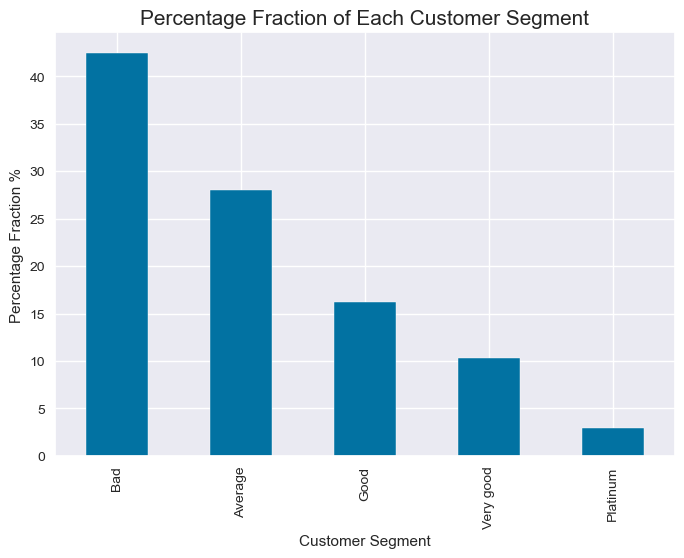

In [100]:
# Percentage composition of each fraction
(RFM['Customer_segment'].value_counts(normalize=True)*100).plot(
    kind='bar',xlabel='Customer Segment',ylabel='Percentage Fraction %'
)
plt.title('Percentage Fraction of Each Customer Segment',size=15);

### Observations:

- We observe that around 3% of customers are in platinum category.These are the most loyal customers that achieved the best scores in all the three RFM. 
- On the flip side, The bad category accounts for majority of the customers. These are those who are less concerned about the business. They are majorly inactive and put in very little effort.The organization should implement strategic marketing techniques to win these customers back in to becoming active in making purchases from the online store.
- Combining 16% of the Good customers and  10% of the very good customers,refers to those who are genuine and honest with the business.
- Finally, the Average customers covering about 28% of the customer base are basically indifferent. Better marketing strategies should be chanelled to this group of customers to increase orders and purchase.

##### Lets get a closer look at the RFM for each category of customers!

In [101]:
RFM.groupby('Customer_segment')['Recency','Frequency','Monetary'].mean().round(0)

,Recency,Frequency,Monetary
Customer_segment,,,
Bad,166.0,1.0,394.0
Average,60.0,3.0,1081.0
Good,26.0,5.0,2226.0
Very good,13.0,11.0,4456.0
Platinum,7.0,32.0,25458.0


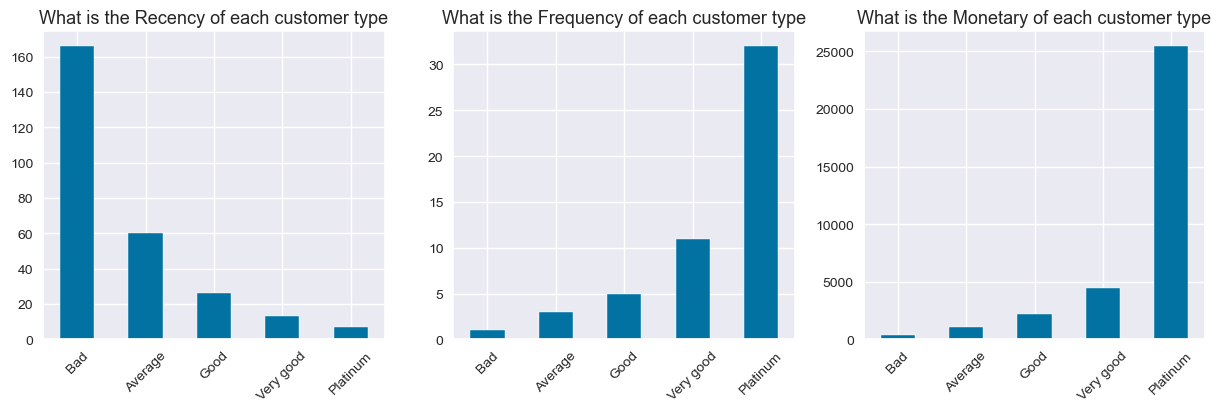

In [102]:
column = ['Recency','Frequency','Monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    RFM.groupby('Customer_segment')[j].mean().round(0).plot(kind='bar')
    plt.title('What is the {} of each customer type'.format(j), size=13)
    plt.xlabel('')
    plt.xticks(rotation=45)

plt.show()

##### Observations

- Irresepective of the very little population of customers in the "Platinum Category", this category is by far a major contributor to the revenue generated by the Online Retail Store. 
- Special offers and appreciation gifts can be given to these customers as a form of recognition and to strengthen their business relationship with the organization.

### Recency vs Frequency vs Monetary

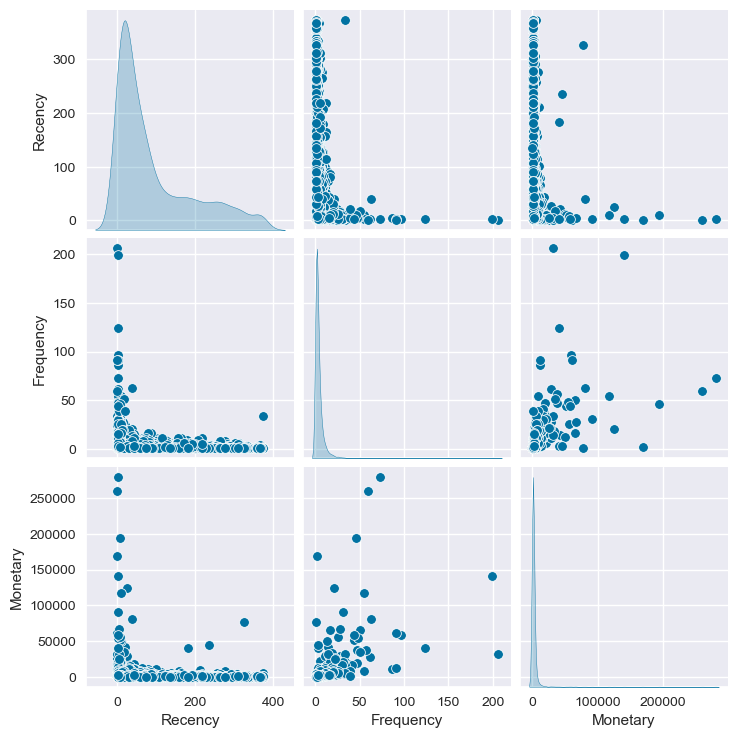

In [103]:
sns.pairplot(RFM[['Recency','Frequency','Monetary']],diag_kind='kde');

There is a strong positive correlation between the frequency of purchase and the monetary value of the customer base.It is safe to say that the high monetary value of customers is strongly linked to a high frequency of purchase.It will be very profitable for the organization to implement marketing strategies that boost the low frequency numbers of the less active customers as this in turn can increase their monetary value and also increase revenue generation for the online store. 

## KMeans-Clustering

K means is one of the most widely used algorithms for clustering data and falls into the unsupervised learning group of machine learning models. It’s ideal for many forms of customer segmentation. Unlike supervised learning models, unsupervised learning models work by identifying previously undetected patterns in data without the benefit of a label to teach the model what to do.

### How does the algorithm work?

Mathematically, the algorithm aims to minimise the within-cluster sum of square distances from the mean or SSE. The algorithm therefore:
- assigns each observation to the nearest cluster
- updates the centroid by calculating the mean of each observation in the cluster 
- repeats the above processes until it is unable to gain further improvement.

# Market Segmentation Using KMeans Clustering

   Customer Segmentation is meant to help identify your ICP, or Ideal Customer Profile, by identifying the segments of customers that perform best. We can measure this by comparing segments on metrics such as RFM, MRR/Customer, Cost to Serve, and CRRPD. These metrics can help you identify which customer segments are profitable, those who pay you the most, and the customer who calls in the most support and success tickets. By comparing these metrics across customer segments you will find the characteristics that define your best performing customer segments. You can take that information and help make operational decisions around customer marketing, acquisition, and retention.

Unsupervised learning models are simply given a set of data and told to put the data into groups based on the similarities of the data within. For a clustering algorithm on a customer data set, this might be the placement of customers into clusters based on their recency, frequency, or monetary value, the products they purchase, or a combination of many features.

The model creates clearly define customer segments based on a number of different features and is used to assign a cluster label to each group. For example, you might call these gold, silver, and bronze if they’re based on customer values. The segments can then be used to modify the way in which the customers receive marketing or customer service levels based on the segment to which they’ve been assigned.

I will be using the KMeans clustering algorithm to segment the customers based on similar behavioural characterics (Recency, frequency and Monetary Values).
Then, I will compare the clustering results with the created customer segments fro the RFM analysis based on RFM scores.

In [104]:
# Preview the data
df_kmeans=RFM.iloc[:,:4].copy()
df_kmeans.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


In [105]:
# Statistical examination of the data
df_kmeans.describe()

,CustomerID,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,93.196354,4.257960,2037.931925
std,1721.994109,100.172795,7.656086,8967.191539
min,12346.000000,1.000000,1.000000,3.750000
25%,13812.250000,18.000000,1.000000,306.452500
50%,15297.500000,51.000000,2.000000,668.495000
75%,16778.750000,143.000000,5.000000,1651.892500
max,18287.000000,374.000000,206.000000,280206.020000


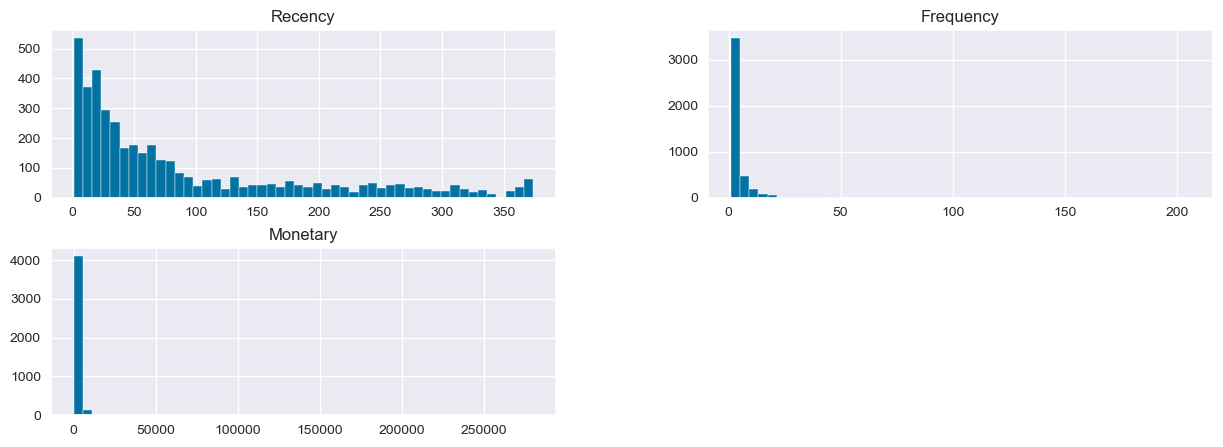

In [106]:
#Select useful columns for the algorithm
df_kmeans.drop(columns=['CustomerID'],inplace=True)
# Distribution of column variables
df_kmeans.hist(figsize=(15,5),
               bins=50);

The K-Means algorithm expects our data to have equal variance, but the mean and std for each metric indicates that this isn’t the case.Also,the statistical distributions of the data using a set of Pandas histograms shows that the data are strongly skewed. This is perfectly normal for RFM data, but it shows that we need to preprocess the data first to resolve this.We will transform the data to make the distribution normal.

In [107]:
#Function for data preprocessing
def data_transform(df):
    """Preprocess data for KMeans clustering"""
    scaler=StandardScaler()
    scaler.fit(df)
    norm_data=scaler.transform(df)
    df_norm=pd.DataFrame(norm_data,columns=df.columns)
    return df_norm, norm_data
    

In [108]:
# Call the funtion for data normalization
df_norm, norm=data_transform(df_kmeans)

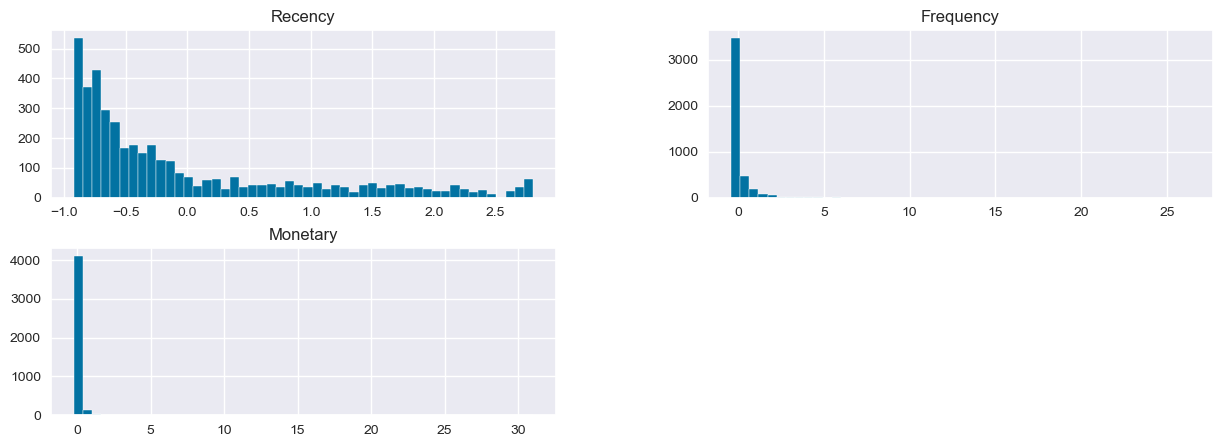

In [109]:
df_norm.hist(figsize=(15,5),
               bins=50);

In [110]:
df_norm.describe()

,Recency,Frequency,Monetary
count,4.334000e+03,4.334000e+03,4.334000e+03
mean,-2.382343e-18,-4.336889e-17,-5.995883e-18
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.204794e-01,-4.255877e-01,-2.268733e-01
25%,-7.507530e-01,-4.255877e-01,-1.931128e-01
50%,-4.212843e-01,-2.949576e-01,-1.527340e-01
75%,4.972347e-01,9.693273e-02,-4.305517e-02
max,2.803516e+00,2.635359e+01,3.102423e+01


In K-means clustering, elbow method and silhouette analysis or score techniques are used to find the number of clusters in a dataset. The elbow method is used to find the “elbow” point, where adding additional data samples does not change cluster membership much. Silhouette score determines whether there are large gaps between each sample and all other samples within the same cluster or across different clusters.

In [111]:
def elbow_method(X, no_k):
    """"Create graphical representation of the Elbow-method for optimal K-value """
    wcss=[]
    for k in range(1,no_k):
        kmeans=KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
       
    
    plt.figure(figsize=(15,5))
    plt.grid()
    plt.plot(range(1,no_k), wcss, linewidth=2, color='red', marker="8")
    plt.xlabel("k Value")
    plt.xticks(np.arange(1,no_k,1))
    plt.ylabel('WCSS')
    plt.title('K-Means Inertia graph for optimal K-value', size=15)
    plt.show();

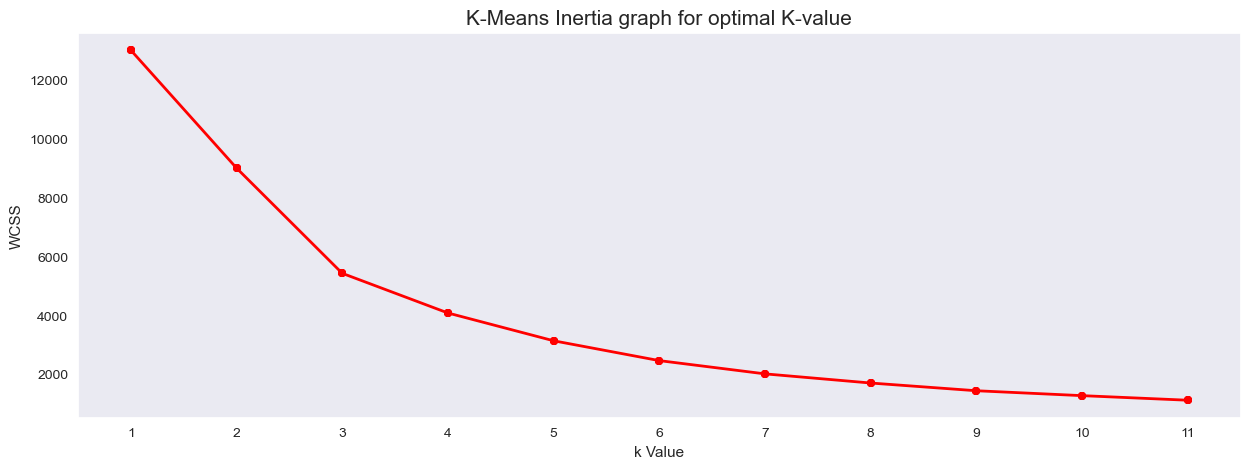

In [112]:
elbow_method(norm, 12)

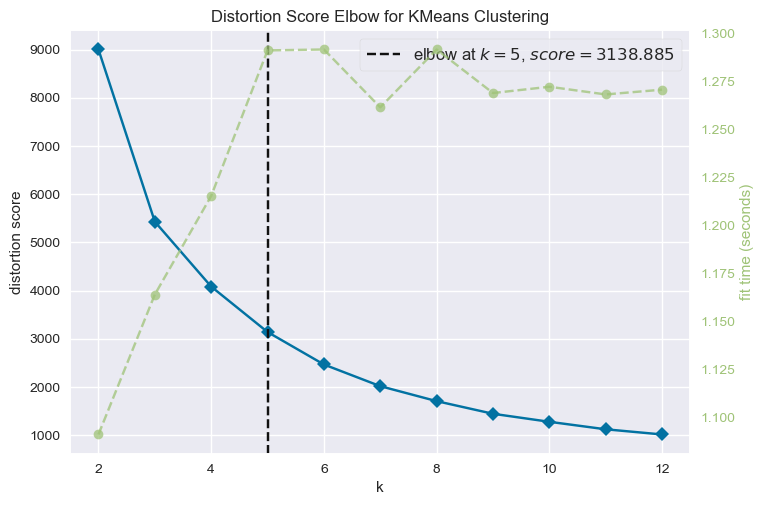

In [113]:
model = KElbowVisualizer(KMeans(random_state=42), k=12)
model.fit(norm)
model.show();

The elbow-method sometimes does not exactly give us a distinct optimal value for k. We should always keep in mind that the elbow method does not work well if the data is not very clustered. If you don’t see a skewed graph then you will not be able to find the accurate number of clusters. The plot shows that the optimal k-values is 5. In order to validate the optimal k-value, we will determine Silhouette coefficients to choose the optimal k-value. Higher values corresponds to the most suitable k-value. 

In [114]:
def silhouette_coefficients(X,start_k,stop_k):
    """"Create graphical representation of the silhouettte score method for optimal K-value """
    sil=[]
    k=range(start_k,stop_k+1)
    for i in k:
        kmeans=KMeans(n_clusters=i, max_iter=50, random_state=42)
        kmeans.fit(X)
        labels=kmeans.labels_
        sil_score=silhouette_score(X,labels)
        sil.append(sil_score)
    avg_score=sum(sil)/len(sil)    
    print("Average silhouette score=",avg_score)
    plt.plot(k,sil,linewidth=2, color='red', marker="8")
    plt.axhline(y=avg_score,linewidth=2,ls='--',label='Average score')
    plt.xlabel('Number of clusters(k)')
    plt.ylabel('Silhouettte score')
    plt.title('silhouettte score Method for Optimal k',size=15)
    plt.legend()
    plt.show();        

Average silhouette score= 0.6770629516566734


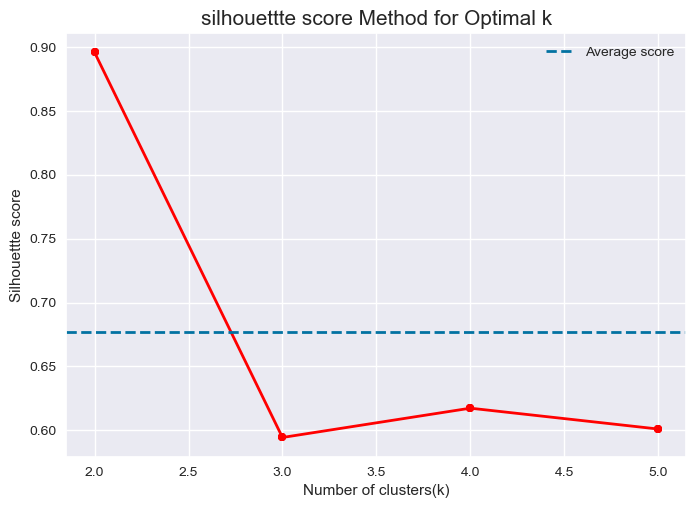

In [115]:
silhouette_coefficients(norm,2,5)

From the plot, we observe that using 2 clusters gives a very high silhouette score, by far above the average score and very close to 1.While the score obtained using 3 clusters is comparatively very low.The optimal k-value for clustering corresponds to k=2

In [116]:
X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
kmeans=KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels=kmeans.predict(X)
labels

array([1, 1, 1, 0, 0, 0])

In [117]:
#Implement KMeans algorithm with k=2
kmeans=KMeans(n_clusters=2, random_state=42)
kmeans.fit(norm)
labels=kmeans.predict(norm)

In [118]:
# Append the cluster labels to the dataset
df_kmeans['Cluster']=labels
df_kmeans.head()

,Recency,Frequency,Monetary,Cluster
0,326,1,77183.60,0
1,3,7,4310.00,0
2,76,4,1797.24,0
3,19,1,1757.55,0
4,311,1,334.40,0


##### Further Analysis on clusters

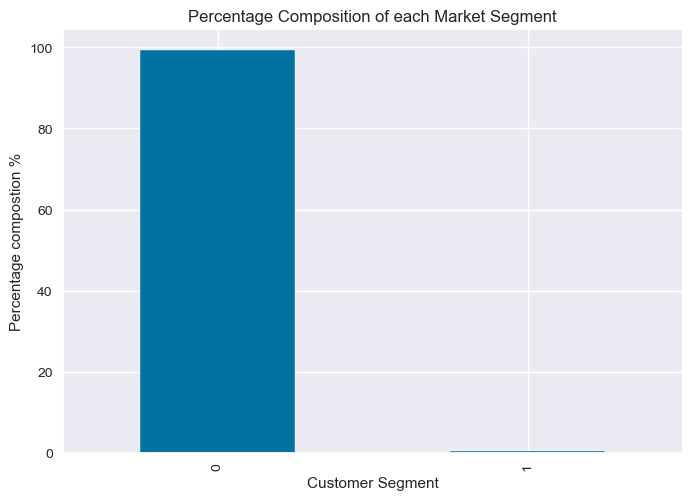

In [119]:
#How many customers are in each segment?
(df_kmeans['Cluster'].value_counts(normalize=True)*100).plot(
    kind='bar',xlabel='Customer Segment',ylabel='Percentage compostion %'
)
plt.title('Percentage Composition of each Market Segment');

Over 90% of the customer base fall into the first category and a very minute are in the second category. This can narrow the marketing strategies that will be carried out by the organization depending on the behaviours of each customer segment.

In [120]:
df_kmeans.groupby('Cluster')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,93.719824,3.884633,1533.478536
1,6.461538,66.115385,85621.978077


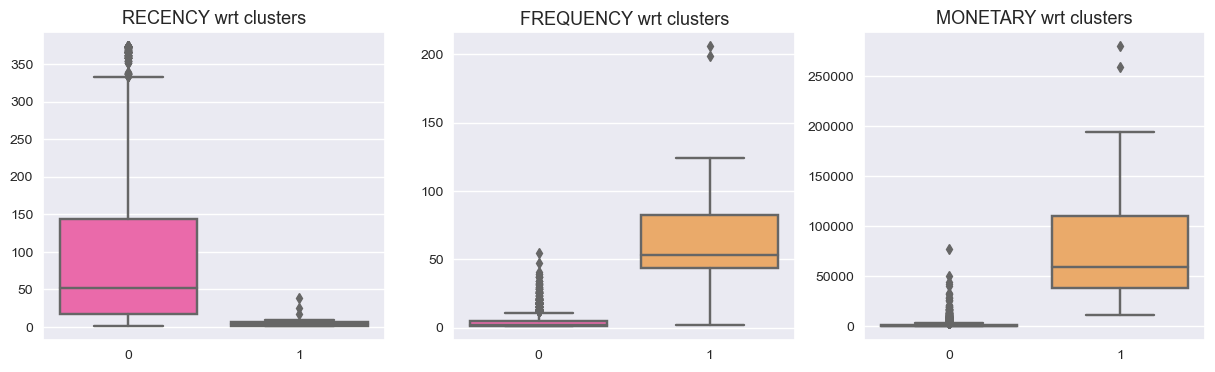

In [121]:
column = ['Recency','Frequency','Monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df_kmeans[j], x=df_kmeans['Cluster'], palette='spring')
    plt.title('{} wrt clusters'.format(j.upper()), size=13)
    plt.ylabel('')
    plt.xlabel('')

plt.show()

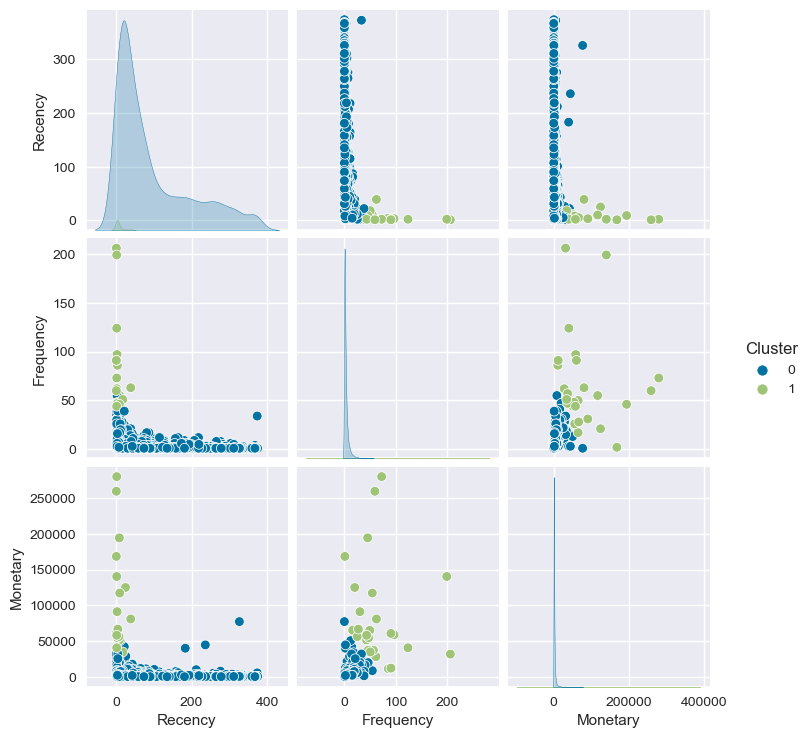

In [122]:
sns.pairplot(df_kmeans, hue='Cluster');

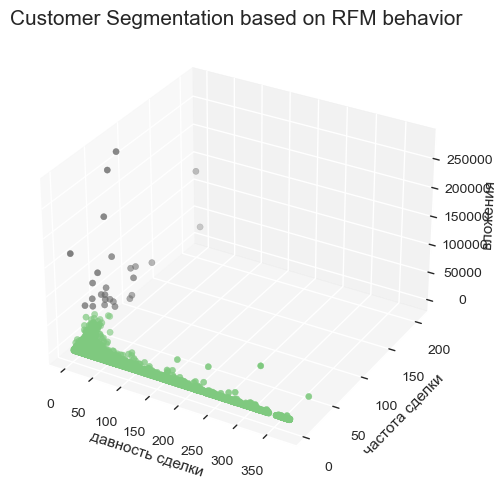

In [123]:
#3D-Visuzlization of the 2 clusters 
# Creating figure
fig = plt.figure(figsize = (8, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(df_kmeans.Recency, df_kmeans.Frequency, df_kmeans.Monetary, c=df_kmeans.Cluster, cmap='Accent')
ax.set_xlabel('давность сделки')
ax.set_ylabel('частота сделки')
ax.set_zlabel('вложения')
plt.title('Customer Segmentation based on RFM behavior', size=15)
ax.set(facecolor='white')
plt.tight_layout()
plt.show();

In [127]:
#Interactive 3D-visualization of customer segments
df_kmeans['Cluster']=df_kmeans['Cluster'].astype('category')
fig = px.scatter_3d(df_kmeans,
                    x=df_kmeans.Recency,
                    y=df_kmeans.Frequency,
                    z=df_kmeans.Monetary,
                    labels={'Recency':'давность сделки','Frequency':'частота сделки','Monetary':'вложения'},
                    title='Visualization of Customer Segmentation based on RFM behavior',
              color='Cluster')
fig.update_layout(showlegend=True)
fig.show()

# Conclusion

- The developed clustering algorithm identified 2 distinct clusters of customers.These customer segments can be identified as the Platinum group (the black points) and the average group (green points) of customers.
- The Platinum group is characterized by high frequency,high monetary value and a very good recency rate. While the average group is associated with relatively low frequency, low monetary value and a very poor recency rate.
- It should be noted that majority of the customer base fall under the average group and about 98% of the organization's revenue is generated by the platinum group of customers even though they occupy about 1% of the organization's customer base.
- It is advisable to keep the platinum group of cutomers at all cost:
    - Setting up a loyalty program: The platinum group of customers should be rewarded for their loyalty.If a customer doesn’t feel appreciated, all it takes is one mistake or a “better opportunity” with a competitor for them to jump ship. It’s important that you don’t take your loyal customers for granted. Reward them for sticking around. 
    
    
- Some marketing strategies that can increase the activity of the average group of customer are:
    - The Use of Gamification To Keep Customers Invested: Gamification is a crucial customer retention strategy, tapping into customers’ desire to feel engaged and rewarded beyond a single transaction. Retail spaces use gamification by turning the dollar amount of money spent in their stores into points applied toward future purchases. This approach provides a good reason for a shopper to become a repeat customer; the money they spent yesterday becomes the discount for tomorrow’s purchase.Retained customers may make purchases repeatedly, storing points for a significant discount on an item they might not be able to afford otherwise. Through fun little rewards or missions, you can transform the shopping experience into a long-term adventure for shoppers, using mechanics that one had only expected to find in an online role-playing game.

    - Provide “Buy Now, Pay Later” Options: It is no surprise that the “buy now, pay later” (BNPL) model has exploded in popularity in recent years.The BNPL model offers a budget-friendly and transparent method of making purchases, and its growing popularity suggests customers could favor shopping with businesses that make such payment options available.

    - The organization can adopt referral systems of advertisement to increase customer-purchase traffic.
    
    - Create a customer feedback loop: One of the biggest keys to retaining customers is to know how they feel. When you understand customer sentiment and what they like/dislike, you can take action on their feedback, refine your approach, and better meet their needs.This can be accomplished by sending customer surveys, adopting customer feedback mechanism upon delivery.
    
   

In [125]:
np.version.version

'1.21.4'